# Transfer Learning

## Setup

In [1]:
import numpy as np
import time

import PIL.Image as Image

import tensorflow as tf
import tensorflow_hub as hub

import datetime

from google.colab import drive

from keras.models import load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)
DATASET_URI= path + "/raw-img"
print("Path to dataset files:", DATASET_URI)

Path to dataset files: /kaggle/input/animals10
Path to dataset files: /kaggle/input/animals10/raw-img


## Data preprocessing

In [3]:
import keras
import matplotlib.pyplot as plt
import random

# Same values as for the 5th model

random.seed(10)
batch_size = 64 # Batch size increase to 64
img_height = 224
img_width = 224
seed = random.randint(1, 200)

train_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True
)

test_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True
)

# We print the class names for double check.

print(f"Training classes => {train_ds.class_names}")
print(f"Testing classes => {test_ds.class_names}")


Found 26179 files belonging to 10 classes.
Using 23562 files for training.
Found 26179 files belonging to 10 classes.
Using 2617 files for validation.
Training classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Testing classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [4]:
class_names = np.array(train_ds.class_names)
print(class_names)

['cane' 'cavallo' 'elefante' 'farfalla' 'gallina' 'gatto' 'mucca' 'pecora'
 'ragno' 'scoiattolo']


In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


## Load the classifier

In [12]:
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
classifier_model = inception_v3

IMAGE_SHAPE = (img_height, img_width)

class MyKerasLayer(keras.layers.Layer): # Create a custom layer inheriting from Layer
    def __init__(self, handle, **kwargs):
        super(MyKerasLayer, self).__init__(**kwargs)
        self.handle = handle

    def build(self, input_shape):
        self.hub_layer = hub.KerasLayer(self.handle, trainable=False)
        super(MyKerasLayer, self).build(input_shape)

    def call(self, inputs):
        return self.hub_layer(inputs)

# classifier = Sequential([
#     MyKerasLayer(classifier_model, input_shape=IMAGE_SHAPE + (3,)) # Use the custom layer
# ])

classifier = keras.Sequential([
    MyKerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

<ipython-input-12-a39bb8206d7c>:8: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(MyKerasLayer, self).__init__(**kwargs)


## Run the classifier

In [14]:
# Get the predictions for your dataset
result_batch = classifier.predict(train_ds)

# Get the top 1 prediction for each image (assuming the model outputs probabilities for all 1001 ImageNet classes)
predicted_class_indices = tf.math.argmax(result_batch, axis=-1)

# Limit the predicted indices to the valid range of your dataset's classes
predicted_class_indices = tf.clip_by_value(predicted_class_indices, 0, len(class_names) - 1)

# Map the predicted indices to the class names in your dataset
predicted_class_names = class_names[predicted_class_indices]

print(predicted_class_names)

369/369 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step
['scoiattolo' 'scoiattolo' 'scoiattolo' ... 'scoiattolo' 'ragno'
 'scoiattolo']


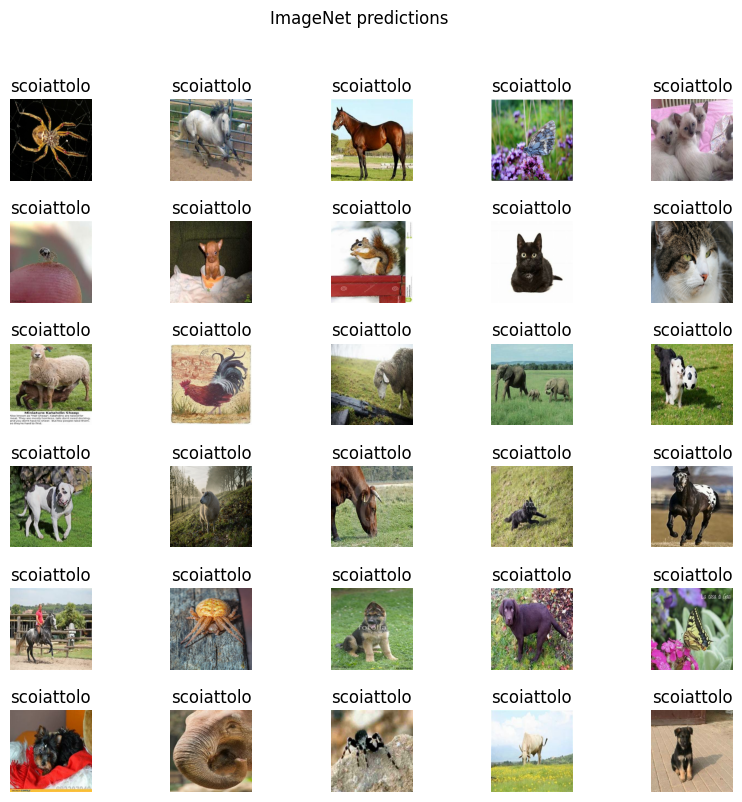

In [15]:
# Check how these predictions line up with the images

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# V2

In [16]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

classifier_model_2 = mobilenet_v2

In [18]:
IMAGE_SHAPE = (224, 224)

class MyKerasLayer(keras.layers.Layer): # Create a custom layer inheriting from Layer
    def __init__(self, handle, **kwargs):
        super(MyKerasLayer, self).__init__(**kwargs)
        self.handle = handle

    def build(self, input_shape):
        self.hub_layer = hub.KerasLayer(self.handle, trainable=False)
        super(MyKerasLayer, self).build(input_shape)

    def call(self, inputs):
        return self.hub_layer(inputs)

classifier_2 = keras.Sequential([
    MyKerasLayer(classifier_model_2, input_shape=IMAGE_SHAPE+(3,))
])

<ipython-input-18-2cd6c212dd9a>:5: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(MyKerasLayer, self).__init__(**kwargs)


Run on single model

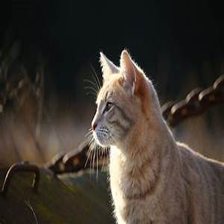

In [21]:
cat = Image.open("/kaggle/input/animals10/raw-img/gatto/1011.jpeg").resize(IMAGE_SHAPE)
cat

In [22]:
cat = np.array(cat)/255.0
cat.shape

(224, 224, 3)

Add a batch dimension (with np.newaxis) and pass the image to the model:

In [24]:
result = classifier_2.predict(cat[np.newaxis, ...])
result.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(1, 1001)

In [25]:
predicted_class_2 = tf.math.argmax(result[0], axis=-1)
predicted_class_2

<tf.Tensor: shape=(), dtype=int64, numpy=288>

In [26]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


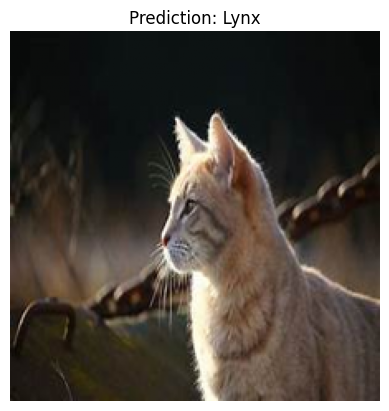

In [27]:
plt.imshow(cat)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class_2]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [31]:
import keras
import matplotlib.pyplot as plt
import random

# Same values as for the 5th model

random.seed(10)
batch_size = 64 # Batch size increase to 64
img_height = 224
img_width = 224
seed = random.randint(1, 200)

train_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True
)

Found 26179 files belonging to 10 classes.
Using 23562 files for training.
Found 26179 files belonging to 10 classes.
Using 2617 files for validation.


In [30]:
italian_to_english = {
    'cane': 'dog',
    'cavallo': 'horse',
    'elefante': 'elephant',
    'farfalla': 'butterfly',
    'gallina': 'chicken',
    'gatto': 'cat',
    'mucca': 'cow',
    'pecora': 'sheep',
    'ragno': 'spider',
    'scoiattolo': 'squirrel'
}

class_names = np.array([italian_to_english[name] for name in train_ds.class_names])
print(class_names)

['dog' 'horse' 'elephant' 'butterfly' 'chicken' 'cat' 'cow' 'sheep'
 'spider' 'squirrel']


In [32]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [33]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [35]:
result_batch = classifier.predict(train_ds)

369/369 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step


In [36]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['horse cart', 'tabby', 'hen', ..., 'fox squirrel', 'cock',
       'fox squirrel'], dtype='<U30')

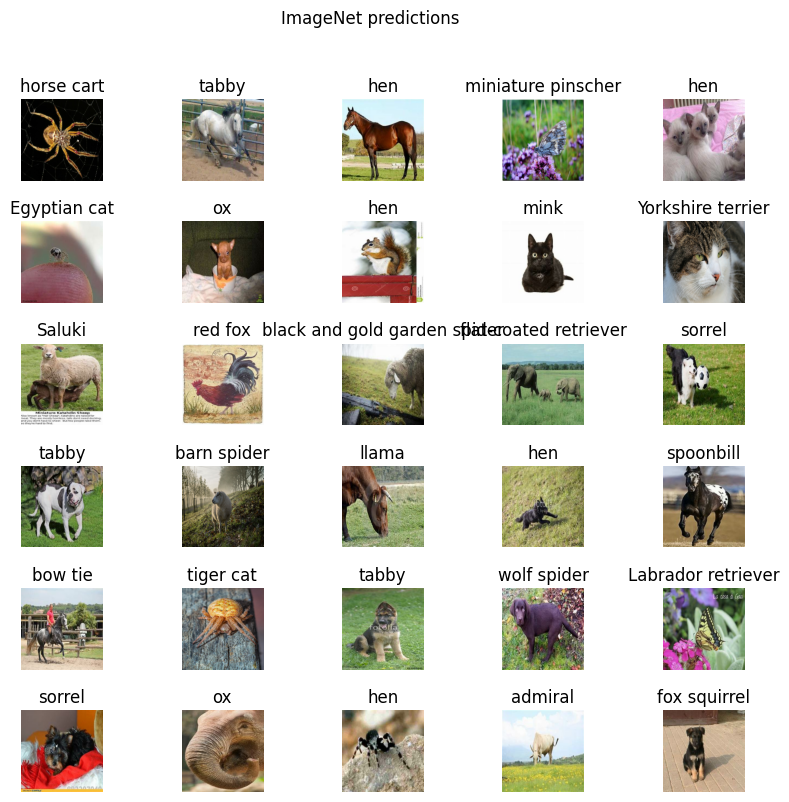

In [37]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Download the headless model

In [39]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [40]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [41]:
feature_batch = feature_extractor_layer(image_batch)

print(feature_batch.shape)

(64, 1280)


In [45]:
num_classes = len(class_names)

class MyKerasLayer(keras.layers.Layer): # Create a custom layer inheriting from Layer
    def __init__(self, handle, **kwargs):
        super(MyKerasLayer, self).__init__(**kwargs)
        self.handle = handle

    def build(self, input_shape):
        self.hub_layer = hub.KerasLayer(self.handle, trainable=False)
        super(MyKerasLayer, self).build(input_shape)

    def call(self, inputs):
        return self.hub_layer(inputs)

model = keras.Sequential([
  MyKerasLayer(feature_extractor_layer),
  tf.keras.layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_keras_layer_4 (MyKerasLayer) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [47]:
predictions = model(image_batch)
predictions.shape

TensorShape([64, 10])

In [48]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [49]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/tensorboard.py:680: UserWarning: Model failed to serialize as JSON. Ignoring... 
Object MyKerasLayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the object must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
  warnings.warn(f"Model failed to serialize as JSON. Ignoring... {exc}")


369/369 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - acc: 0.8434 - loss: 0.5495 - val_acc: 0.9549 - val_loss: 0.1498
Epoch 2/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - acc: 0.9626 - loss: 0.1256 - val_acc: 0.9603 - val_loss: 0.1356
Epoch 3/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - acc: 0.9704 - loss: 0.0994 - val_acc: 0.9603 - val_loss: 0.1320
Epoch 4/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - acc: 0.9761 - loss: 0.0828 - val_acc: 0.9606 - val_loss: 0.1313
Epoch 5/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - acc: 0.9799 - loss: 0.0705 - val_acc: 0.9614 - val_loss: 0.1318
Epoch 6/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - acc: 0.9835 - loss: 0.0610 - val_acc: 0.9614 - val_loss: 0.1330
Epoch 7/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - acc: 0.9864 - loss: 0.0533 - val_acc: 0.9622 - val_loss: 0.1346
Epoch 8/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - acc: 0.9881 - loss: 0.0470 - val_acc: 0.9622 - val_loss: 0.1366
Epoch 9/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/st

In [50]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step
['spider' 'horse' 'horse' 'butterfly' 'cat' 'spider' 'dog' 'squirrel'
 'cat' 'cat' 'sheep' 'chicken' 'sheep' 'elephant' 'dog' 'dog' 'sheep'
 'cow' 'cat' 'horse' 'horse' 'spider' 'dog' 'dog' 'butterfly' 'dog'
 'elephant' 'spider' 'cow' 'dog' 'spider' 'squirrel' 'chicken' 'sheep'
 'squirrel' 'dog' 'spider' 'elephant' 'horse' 'cow' 'dog' 'elephant'
 'horse' 'spider' 'sheep' 'spider' 'squirrel' 'squirrel' 'elephant'
 'spider' 'dog' 'spider' 'chicken' 'chicken' 'butterfly' 'butterfly'
 'butterfly' 'squirrel' 'squirrel' 'dog' 'spider' 'dog' 'chicken'
 'squirrel']


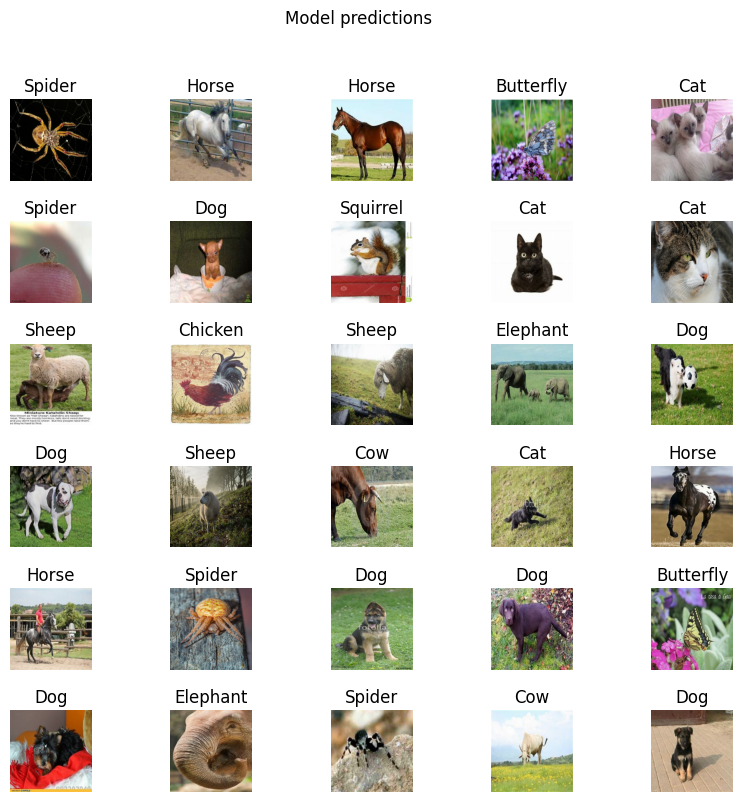

In [51]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")